## Importamos librerías

In [4]:
###### Feature Engineering ######
import pandas as pd
import numpy as np
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

###### Load the API  ######
import requests
import gzip
import io

###### Forecasting ######
from mlforecast import MLForecast
from empresa4.core import calculate_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import lightgbm as lgb 


from empresa4.datasets import nombres_datasets, get_dataset

###### Visualize ######
import matplotlib.pyplot as plt
import seaborn as sns

###### Pipelines ######
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [2]:
# Set the display.max_columns to None to display all columns
pd.set_option('display.max_columns', None)

In [3]:
# Imprime la lista de nombres de datasets
for nombre in nombres_datasets:
    print(nombre)

01_original
01_producto_estrella
01_productos_todos
01_por_cliente
maestro_productos


## Funciones

In [5]:
def cargar_dataset(url, sep='\t', header='infer'):
    """
    Lee un archivo CSV comprimido con gzip desde una URL y lo carga en un DataFrame de Pandas.

    :param url: String con la URL del archivo .gz.
    :param sep: String delimitador para separar campos en el archivo CSV.
    :param header: Parámetro para determinar la fila que debe usarse como nombre de las columnas.
    :return: DataFrame de Pandas con los datos del archivo CSV.
    """
    # Realizar la petición HTTP para obtener el contenido del archivo
    response = requests.get(url)

    # Asegurarse de que la petición fue exitosa
    if response.status_code == 200:
        # Descomprimir el contenido en memoria y leer directamente en un DataFrame
        with io.BytesIO(response.content) as bytes_io:
            with gzip.open(bytes_io, 'rt') as read_file:
                df = pd.read_csv(read_file, sep=sep, header=header)
        return df
    else:
        raise IOError(f"Error al descargar el archivo: {response.status_code}")
    
def read_csv_from_url(url, sep='\t', header='infer'):
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.read_csv(io.StringIO(response.content.decode('utf-8')), sep=sep, header=header)
        return df
    else:
        raise IOError(f"Error al descargar el archivo: {response.status_code}")
    
def plotear_grafico(df):
    # Convertir el 'periodo' a formato de fecha para mejor visualización en el gráfico
    df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')

    # Crear nuevamente el gráfico de línea con Seaborn
    plt.figure(figsize=(14, 7))
    line_plot = sns.lineplot(data=df, x='periodo', y='tn', marker='o', color='blue', linewidth=2.5)

    # Títulos y etiquetas
    line_plot.set_title('Evolución de Toneladas a lo largo del Tiempo', fontsize=16)
    line_plot.set_xlabel('Periodo', fontsize=14)
    line_plot.set_ylabel('Toneladas (tn)', fontsize=14)

    # Establecer el formato del eje x para mostrar todos los periodos
    line_plot.xaxis.set_major_locator(plt.MaxNLocator(len(df['periodo'])))
    line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
    
def fill_missing_months_multi_product(df):
    # Find the earliest and latest period (assuming the format is YYYYMM)
    min_year = df['periodo'].min() // 100
    max_year = df['periodo'].max() // 100

    # Generate all combinations of year and months
    all_periods = pd.DataFrame({
        'periodo': [year * 100 + month for year in range(min_year, max_year + 1) for month in range(1, 13)]
    })

    product_ids = df['product_id'].unique()
    all_period_product_combinations = (
        all_periods.assign(key=1)
        .merge(pd.DataFrame({'product_id': product_ids, 'key': 1}), on='key')
        .drop(columns=['key'])  # Using the 'columns' parameter for clarity
    )

    # Merge with the original DataFrame
    df_complete = all_period_product_combinations.merge(df, on=['periodo', 'product_id'], how='left')

    # Fill the 'tn' column with zeros where there are NaNs
    df_complete['tn'] = df_complete['tn'].fillna(0)

    # Forward fill or backfill other columns that don't change for each product
    columns_to_fill = ['plan_precios_cuidados', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size']
    df_complete.sort_values(by=['product_id', 'periodo'], inplace=True)
    df_complete[columns_to_fill] = df_complete.groupby('product_id')[columns_to_fill].ffill().bfill()
    return df_complete

def generar_delta_lags_optimizado(df, prefijo_lag='lag_', prefijo_delta_lag='delta_lag_'):
    """
    Genera delta lags de manera más eficiente para una columna específica de un DataFrame de pandas.

    :param df: DataFrame original que ya contiene las columnas de lags.
    :param prefijo_lag: Prefijo utilizado para las columnas de lags en el DataFrame.
    :param prefijo_delta_lag: Prefijo utilizado para las nuevas columnas de delta lags.
    :return: DataFrame con las columnas de delta lags añadidas.
    """
    
    # Identificar todas las columnas de lags en el DataFrame
    columnas_lags = [col for col in df.columns if col.startswith(prefijo_lag)]
    
    # Generar las columnas de delta lags
    for i in range(len(columnas_lags) - 1):
        col_lag_actual = columnas_lags[i]
        col_lag_siguiente = columnas_lags[i + 1]
        df[prefijo_delta_lag + str(i + 1)] = df[col_lag_actual] - df[col_lag_siguiente]
    
    return df

# Re-creating the optimized lag generation function after the reset
def generar_lags_optimizado(df, nombre_col_original='tn', cant_lags=12):
    """
    Genera lags de manera más eficiente para una columna específica de un DataFrame de pandas.

    :param df: DataFrame original.
    :param nombre_col_original: Nombre de la columna sobre la cual se quieren calcular los lags.
    :param cant_lags: Cantidad de lags a generar.
    :return: DataFrame con las columnas de lags añadidas.
    """
    
    # Obtener una lista de productos únicos
    productos_unicos = df['product_id'].unique()
    
    # Preparar un contenedor para los DataFrames de lags
    lags_list = []
    
    # Iterar sobre cada producto único
    for producto in productos_unicos:
        # Filtrar el DataFrame por producto
        df_producto = df[df['product_id'] == producto].copy()
        
        # Generar lags para la columna deseada
        for lag in range(1, cant_lags + 1):
            df_producto[f'lag_{lag}'] = df_producto[nombre_col_original].shift(lag)
        
        # Añadir el DataFrame de lags a la lista
        lags_list.append(df_producto)
    
    # Concatenar todos los DataFrames de lags
    df_con_lags = pd.concat(lags_list).sort_index()
    
    return df_con_lags

def generar_medias_optimizado(df, nombre_col_original='tn', lista_medias_target=[2,3,4,6,10], prefijo_col_media='media'):
    """
    Genera las medias móviles de los últimos N meses de manera más eficiente para una columna específica de un DataFrame de pandas.

    :param df: DataFrame original.
    :param nombre_col_original: Nombre de la columna sobre la cual se quieren calcular las medias móviles.
    :param lista_medias_target: Lista de enteros que representan el número de meses para calcular la media móvil.
    :param prefijo_col_media: Prefijo para las nuevas columnas de medias móviles.
    :return: DataFrame con las columnas de medias móviles añadidas.
    """
    
    # Obtener una lista de productos únicos
    productos_unicos = df['product_id'].unique()
    
    # Preparar un contenedor para los DataFrames de medias móviles
    medias_list = []
    
    # Iterar sobre cada producto único
    for producto in productos_unicos:
        # Filtrar el DataFrame por producto
        df_producto = df[df['product_id'] == producto].copy()
        
        # Generar medias móviles para cada ventana especificada en lista_medias_target
        for ventana in lista_medias_target:
            col_media = f'{nombre_col_original}_{prefijo_col_media}_{ventana}'
            df_producto[col_media] = df_producto[nombre_col_original].rolling(window=ventana).mean().shift()
        
        # Añadir el DataFrame de medias móviles a la lista
        medias_list.append(df_producto)
    
    # Concatenar todos los DataFrames de medias móviles
    df_con_medias = pd.concat(medias_list).sort_index()
    
    return df_con_medias

# Custom transformer for label encoding multiple columns
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
    
    def fit(self, X, y=None):
        for column in X.columns:
            self.encoders[column] = LabelEncoder().fit(X[column])
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        for column in X.columns:
            X_encoded[column] = self.encoders[column].transform(X[column])
        return X_encoded
    
    def inverse_transform(self, X):
        X_decoded = X.copy()
        for column in X.columns:
            X_decoded[column] = self.encoders[column].inverse_transform(X[column])
        return X_decoded

## Importamos Datasets

In [6]:
df_clientes = get_dataset("01_por_cliente")
df_productos = get_dataset("01_productos_todos")
df_estrella = get_dataset("01_producto_estrella")
df_original = get_dataset("01_original")

In [7]:
# URL del archivo .gz
url_tb_sellout_02 = 'https://storage.googleapis.com/open-courses/austral2023-labo3-d0e5/tb_sellout_02.txt.gz'
url_tb_stocks_02 = 'https://storage.googleapis.com/open-courses/austral2023-labo3-d0e5/tb_stocks_02.txt.gz'
url_tb_productos_02 = 'https://storage.googleapis.com/open-courses/austral2023-labo3-d0e5/tb_productos_02.txt'

# Uso de la función
df_tb_sellout_02 = cargar_dataset(url_tb_sellout_02)
df_tb_stocks_02 = cargar_dataset(url_tb_stocks_02)
df_tb_productos_02= read_csv_from_url(url_tb_productos_02)

In [8]:
# Productos distintos
df_tb_productos_02.product_id.drop_duplicates().count()

1251

## Pre Processing

In [8]:
# Juntamos los datasets Sellout con el maestro de productos
df_sellout_with_cat = pd.merge(df_tb_sellout_02, df_tb_productos_02[['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size']], on='product_id', how='left')
# Agrupamos por categorías de productos
df_aggregated = df_sellout_with_cat.groupby(['periodo', 'product_id', 'plan_precios_cuidados', 
                                             'cat1', 'cat2', 'cat3', 'brand', 'sku_size']).agg({'cust_request_tn': 'sum','tn': 'sum'}).reset_index()

## Análisis Exploratorio

/tmp/ipykernel_77600/3189247823.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to ge

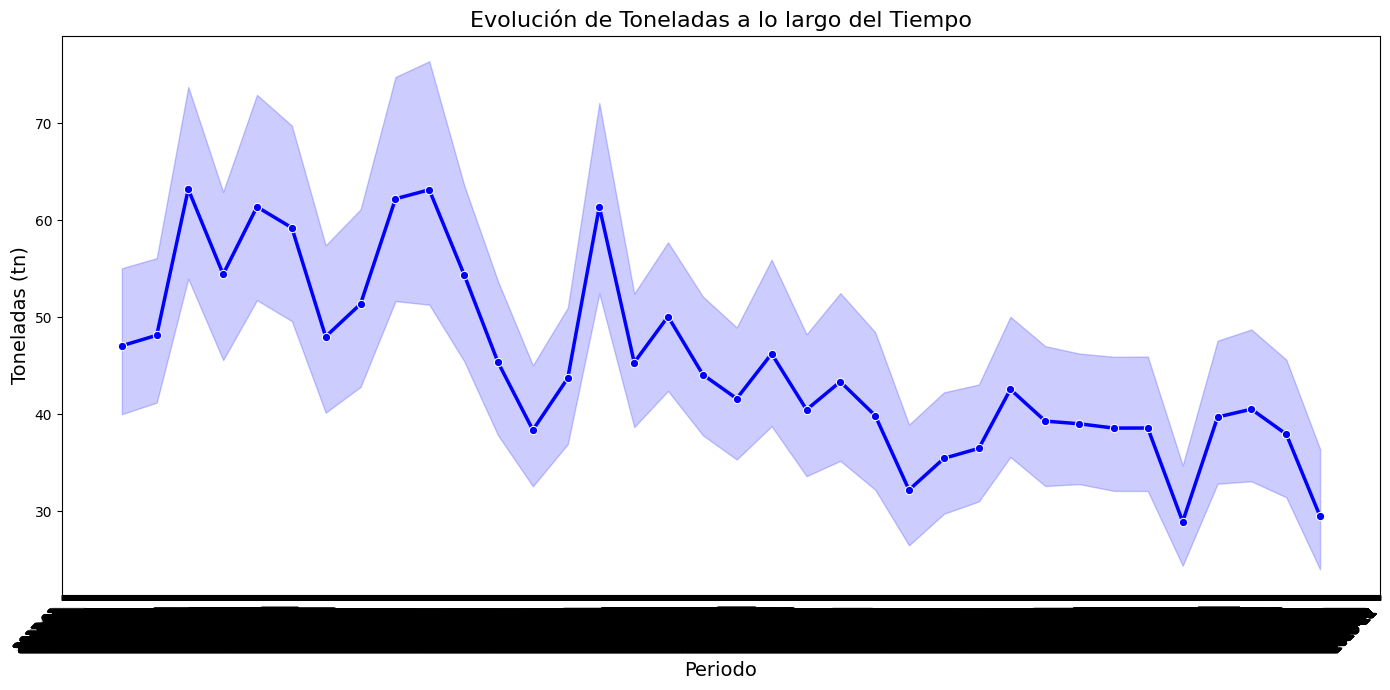

In [9]:
# Producto Estrella
plotear_grafico(df_aggregated)

In [10]:
# Todos los productos
plotear_grafico(df_productos_grouped)

NameError: name 'df_productos_grouped' is not defined

In [ ]:
# Todos los productos de FOODS
plotear_grafico(df_productos_cat_foods)

In [ ]:
df_productos_cat_ref = df_productos_cat_grouped[df_productos_cat_grouped.product_category=='REF']

In [ ]:
# Todos los productos de HC
plotear_grafico(df_productos_cat_hc)

In [ ]:
# Todos los productos de PC
plotear_grafico(df_productos_cat_pc)

In [ ]:
# Todos los productos de REF
plotear_grafico(df_productos_cat_ref)

## Feature Engineering

In [ ]:
# Llamamos a la función para rellenar los registros faltantes
df_complete = fill_missing_months_multi_product(df_aggregated)
# Generamos los lags
df_complete_lags = generar_lags_optimizado(df_complete)
# Utilizamos el DataFrame con lags generado anteriormente para crear los delta lags
df_complete_delta_lags = generar_delta_lags_optimizado(df_complete_lags)
# Utilizamos el DataFrame con lags generado anteriormente para crear las medias móviles
df_final = generar_medias_optimizado(df_complete_delta_lags)
df_final = df_final.fillna(0)

## Cross Validation por corte temporal

In [ ]:
# Assuming df_final is the DataFrame you want to split into train and validation sets:
df_final['periodo'] = pd.to_datetime(df_final['periodo'], format='%Y%m')

# Cortamos hasta Febrero inclusive como TRAIN
train = df_final[df_final['periodo'] <= pd.to_datetime('201902', format='%Y%m')]
# Usamos MARZO como test
valid_marzo = df_final[df_final['periodo'] == pd.to_datetime('201903', format='%Y%m')]
# Usamos Abril como testing del PIPELINE
valid = df_final[df_final['periodo'] == pd.to_datetime('201903', format='%Y%m')]

# Para predecir Marzo
X_train = train.drop(columns=['tn', 'periodo'])
y_train = train['tn']
X_test = valid_marzo.drop(columns=['tn', 'periodo'])
y_test = valid_marzo['tn']

## Modeling

### Pipeline multiples algoritmos (código de Gustavo)

In [ ]:
# List of dynamic features used during training
dynamic_features = ['cust_request_tn','lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'delta_lag_1', 'delta_lag_2',
       'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6',
       'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10',
       'delta_lag_11', 'tn_media_2', 'tn_media_3', 'tn_media_4', 'tn_media_6',
       'tn_media_10']

# Prepare the DataFrame with the required features for prediction
dynamic_df_for_prediction = valid_marzo[['product_id', 'periodo'] + dynamic_features]

In [ ]:
# Specify the categorical columns you want to encode
categorical_columns = ['cat1', 'cat2', 'cat3', 'brand']

# Create a ColumnTransformer with the custom transformer for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', MultiColumnLabelEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # This leaves the rest of the columns untouched
)

# Now include LGBMRegressor in your list of models
models = [
    Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest', RandomForestRegressor(random_state=0, n_estimators=100))
    ]),
    Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', XGBRegressor(random_state=0, n_estimators=100))
    ]),
    Pipeline([
        ('preprocessor', preprocessor),
        ('lightgbm', lgb.LGBMRegressor(random_state=0, n_estimators=100))  # Add LGBMRegressor
    ])
]

# Assuming MLForecast is a class that has been defined to take these models
model = MLForecast(models=models,
                   freq='M',
                   lags=[1,2,3,4,5,6,7,8,9,10,11,12],
                   lag_transforms={
                       1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                   },
                   date_features=['month'],
                   num_threads=6)


In [ ]:
# Step 1: Train the model
model.fit(train, id_col='product_id', time_col='periodo', target_col='tn')

In [ ]:
# Step 2: Predict one period ahead
predictions = model.predict(horizon=3, dynamic_dfs=[dynamic_df_for_prediction])
predictions.rename(columns={'Pipeline': 'random_forest', 
                            'Pipeline2': 'xgboost', 
                            'Pipeline3': 'lightgbm'}, inplace=True)

In [ ]:
# Hacer una copia para evitar SettingWithCopyWarning
valid_set = valid[['product_id', 'periodo', 'tn']].copy()

# Convertir la columna 'periodo' al formato deseado
valid_set['periodo'] = pd.to_datetime(valid_set['periodo']).dt.strftime('%Y%m')

# Solo necesitas hacer esto si 'predictions' no está ya en el formato AAAAMM
predictions['periodo'] = pd.to_datetime(predictions['periodo']).dt.strftime('%Y%m')

# Fusionar predicciones con el conjunto de validación para comparar los valores reales con los pronósticos
p = predictions.merge(valid_set, on=['product_id', 'periodo'], how='left', suffixes=('', '_actual'))

p = p[p.periodo == '201904']

In [ ]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Here 'p' is your DataFrame containing the actual values and predictions
print(f"SMAPE Random Forest Pipeline: {smape(p['tn'], p['random_forest'])}")
print(f"SMAPE XGBRegressor: {smape(p['tn'], p['xgboost'])}")
print(f"SMAPE LGBMRegressor: {smape(p['tn'], p['lightgbm'])}")


In [ ]:
calculate_error(p.lightgbm.to_numpy(), p.tn.to_numpy())

print(f"Error Rate Random Forest Pipeline: {calculate_error(p.random_forest.to_numpy(), p.tn.to_numpy())}")
print(f"Error Rate XGBRegressor: {calculate_error(p.xgboost.to_numpy(),p.tn.to_numpy())}")
print(f"Error Rate LGBMRegressor: {calculate_error(p.lightgbm.to_numpy(), p.tn.to_numpy())}")

### LGBM

In [ ]:
# Create the LightGBM dataset
categorical_features = ['cat1', 'cat2', 'cat3', 'brand']

# Convert categorical features to 'category' type

for feature in categorical_features:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')


train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)


# Define the parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# Train the model
gbm = lgb.train(params, train_data, num_boost_round=100)

In [ ]:
# Predict on the test set
y_pred_marzo = gbm.predict(X_test)

In [ ]:
y_test_array = y_test.to_numpy()
error = calculate_error(y_pred_marzo, y_test_array)

# Print the error
print(f'The error of the forecast is: {error}')

#### Incluimos las prediccioines de MARZO en el TRAIN para predecir ABRIL

In [ ]:
# Actualizar el conjunto de entrenamiento
new_row = X_test.copy()
train_con_marzo = train.copy()

new_row['tn'] = y_pred_marzo  # Añade la predicción como el valor real de 'tn'
new_row['periodo'] = '2019-03-01'  # Añadir la columna 'periodo'

train_con_marzo = pd.concat([train_con_marzo, new_row])

valid_abril = df_final[['product_id','periodo','plan_precios_cuidados','cat1','cat2','cat3','brand','sku_size','cust_request_tn','tn']]
valid_abril = valid_abril[valid_abril.periodo == '2019-04-01']

# Concatenamos MARZO con el TRAIN
df_complete_2 = pd.concat([train_con_marzo, valid_abril])

#### Generamos el Feature Engineering necesario

In [ ]:
# Generamos los lags
df_complete_lags_2 = generar_lags_optimizado(df_complete_2)
# Utilizamos el DataFrame con lags generado anteriormente para crear los delta lags
df_complete_delta_lags_2 = generar_delta_lags_optimizado(df_complete_lags_2)
# Utilizamos el DataFrame con lags generado anteriormente para crear las medias móviles
df_final_2 = generar_medias_optimizado(df_complete_delta_lags_2)

In [ ]:
# Separamos la Data entre TRAIN y TEST
df_final_2['periodo'] = pd.to_datetime(df_final_2['periodo'], format='%Y-%m-%d')

train_abril = df_final_2[df_final_2['periodo'] <= pd.to_datetime('2019-03-01')]
valid_abril = df_final_2[df_final_2['periodo'] == pd.to_datetime('2019-04-01')]

X_train_abril = train_abril.drop(['tn', 'periodo'], axis=1)
y_train_abril = train_abril['tn']

X_test_abril = valid_abril.drop(columns=['tn', 'periodo'])
y_test_abril = valid_abril['tn']

#### Modelamos nuevamente

In [ ]:
# Create the LightGBM dataset
categorical_features = ['cat1', 'cat2', 'cat3', 'brand']

# Convert categorical features to 'category' type

for feature in categorical_features:
    X_train_abril[feature] = X_train_abril[feature].astype('category')
    X_test_abril[feature] = X_test_abril[feature].astype('category')


train_data_abril = lgb.Dataset(X_train_abril, label=y_train_abril, categorical_feature=categorical_features, free_raw_data=False)


# Define the parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# Train the model
gbm = lgb.train(params, train_data_abril, num_boost_round=100)

In [ ]:
# Predict on the test set
y_pred_abril = gbm.predict(X_test_abril)

In [ ]:
y_test_array = y_test_abril.to_numpy()
error = calculate_error(y_pred_abril, y_test_array)

# Print the error
print(f'The error of the forecast is: {error}')